In [1]:
# import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.inspection import PartialDependenceDisplay

In [2]:
# import the data and  drop no longer needed columns 
video_df = pd.read_csv("data/videos_prepared.csv")

remove_columns = ["video_id", "title", "channel_title"]
video_df.drop(columns=remove_columns, inplace=True)
video_df.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_year,term_years,term_youtu,term_youtube,log_view_count,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
0,0,0,6,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.243155,7.828038,11.927885,7.384610,5.752573,3.555348,9.976612
1,0,20,4,4,1,0,0,0,0,0,...,0.0,0.237726,0.0,0.063338,7.350516,12.850665,8.366603,5.389072,8.147288,11.965177
2,0,18,3,10,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,7.446001,14.875077,8.767329,6.741701,3.951244,13.871269
3,0,19,0,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,5.937536,10.890628,6.786717,4.867534,4.955827,5.325074
4,1,20,2,10,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,12.229037,17.917472,13.030250,5.940171,6.678342,6.431228


In [3]:
# import the data and  drop no longer needed columns 
video_df = pd.read_csv("data/videos_prepared.csv")

remove_columns = ["video_id", "title", "channel_title"]
video_df.drop(columns=remove_columns, inplace=True)
video_df.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_year,term_years,term_youtu,term_youtube,log_view_count,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
0,0,0,6,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.243155,7.828038,11.927885,7.384610,5.752573,3.555348,9.976612
1,0,20,4,4,1,0,0,0,0,0,...,0.0,0.237726,0.0,0.063338,7.350516,12.850665,8.366603,5.389072,8.147288,11.965177
2,0,18,3,10,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,7.446001,14.875077,8.767329,6.741701,3.951244,13.871269
3,0,19,0,11,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,5.937536,10.890628,6.786717,4.867534,4.955827,5.325074
4,1,20,2,10,1,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,12.229037,17.917472,13.030250,5.940171,6.678342,6.431228


In [4]:
# split into features and target variable

X = video_df.drop(columns="log_view_count")
y = video_df["log_view_count"]

# split into training and test data
SEED = 666
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_www,term_year,term_years,term_youtu,term_youtube,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
691,0,19,1,4,1,0,1,0,0,0,...,0.192941,0.0,0.0,0.129062,0.000000,17.608917,12.055256,7.196687,7.220374,9.505998
453,0,7,5,2,1,0,0,0,0,0,...,0.087819,0.0,0.0,0.000000,0.000000,10.013642,5.420535,4.488636,8.782169,8.391942
451,0,11,1,7,1,0,0,0,0,0,...,0.000000,0.0,0.0,0.000000,0.000000,16.309203,10.214679,5.375278,3.178054,3.141381
67,0,20,2,9,1,0,0,1,0,0,...,0.196466,0.0,0.0,0.000000,0.090057,17.445774,12.641100,7.347300,5.463832,7.453040
311,0,17,3,2,1,0,0,0,0,0,...,0.155924,0.0,0.0,0.032594,0.053605,18.167549,13.355063,7.236339,7.712444,13.838275


In [5]:
# hyperparameter tune a decision tree regressor
SEED = 666
params = {"decisiontreeregressor__max_depth": [3, 5, 10, 15, 20, 30, None], "decisiontreeregressor__min_samples_leaf": [2, 4, 6], "decisiontreeregressor__min_samples_split": [2, 5, 10]}
pipeline = make_pipeline(StandardScaler(), DecisionTreeRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.5861119059685386, best params: {'decisiontreeregressor__max_depth': 5, 'decisiontreeregressor__min_samples_leaf': 4, 'decisiontreeregressor__min_samples_split': 10}


In [6]:
# fit decision tree with optimal parameters
dt = DecisionTreeRegressor(max_depth=best_params["decisiontreeregressor__max_depth"], min_samples_leaf=best_params["decisiontreeregressor__min_samples_leaf"], min_samples_split=best_params["decisiontreeregressor__min_samples_split"], random_state=SEED)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = dt.score(X_test, y_test)
print(f"r2: {r2}, rmse: {rmse}")

r2: 0.6336634600979427, rmse: 1.5892726455430004


In [7]:
# instantiate random forest and use randomized cross validation to search wide range of hyperparameters
params = {"randomforestregressor__n_estimators": [100, 200, 300, 500, 1000], "randomforestregressor__max_depth": [10, 20, 30, 50, None], "randomforestregressor__min_samples_leaf": [2, 4, 6],
          "randomforestregressor__max_features": ["sqrt", "log2", None], "randomforestregressor__bootstrap": [True, False]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
rand_search = RandomizedSearchCV(pipeline, param_distributions=params, cv=10, n_iter=50, scoring="r2", n_jobs=-1)
rand_search.fit(X_train, y_train)
best_params = rand_search.best_params_
print(f"best score: {rand_search.best_score_}, best params: {best_params}")

best score: 0.7056940228494926, best params: {'randomforestregressor__n_estimators': 1000, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': None, 'randomforestregressor__max_depth': None, 'randomforestregressor__bootstrap': True}


In [8]:
# use gridsearch for fine-tuning hyperparameters
params = {"randomforestregressor__n_estimators": np.arange(best_params["randomforestregressor__n_estimators"] - 20, best_params["randomforestregressor__n_estimators"] + 30, 10), "randomforestregressor__max_depth": [best_params["randomforestregressor__max_depth"]],
          "randomforestregressor__min_samples_leaf": [best_params["randomforestregressor__min_samples_leaf"]], "randomforestregressor__max_features": [best_params["randomforestregressor__max_features"]],
          "randomforestregressor__bootstrap": [best_params["randomforestregressor__bootstrap"]]}
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(random_state=SEED))
grid_search = GridSearchCV(pipeline, param_grid=params, cv=10, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f"best score: {grid_search.best_score_}, best params: {best_params}")

best score: 0.7056940228494926, best params: {'randomforestregressor__bootstrap': True, 'randomforestregressor__max_depth': None, 'randomforestregressor__max_features': None, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': np.int64(1000)}


In [9]:
# fit random forest with optimal parameters
pipeline = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators=best_params["randomforestregressor__n_estimators"], max_depth=best_params["randomforestregressor__max_depth"], min_samples_leaf=best_params["randomforestregressor__min_samples_leaf"],
                           max_features=best_params["randomforestregressor__max_features"], bootstrap=best_params["randomforestregressor__bootstrap"], random_state=SEED))
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
r2 = pipeline.score(X_test, y_test)
rf = pipeline.named_steps["randomforestregressor"]
print(f"r2: {r2}, rmse: {rmse}")

r2: 0.7252782594321727, rmse: 1.3762736770945825


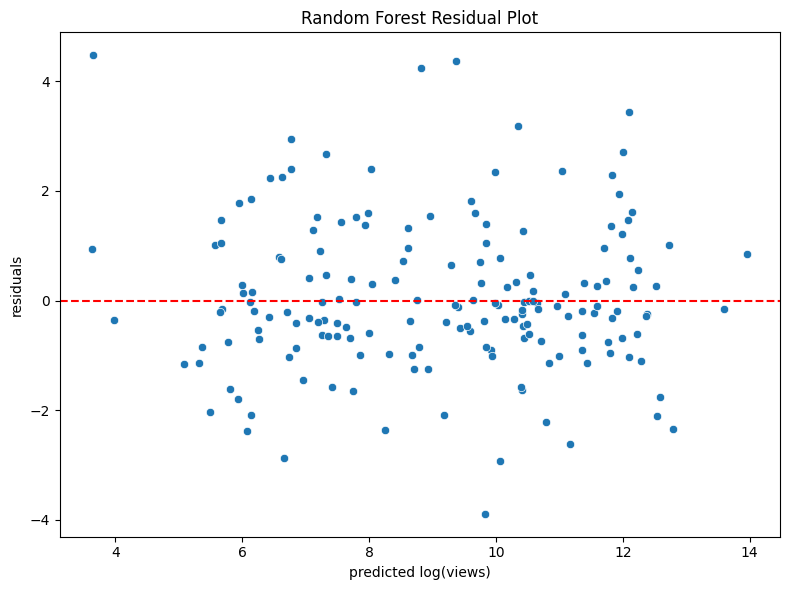

In [10]:
# visualize residuals to look for patterns
residuals = y_test - y_pred
plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("predicted log(views)")
plt.ylabel("residuals")
plt.title("Random Forest Residual Plot")
plt.tight_layout()

# save png
plt.savefig("images/rf_residual_plot.png", dpi=300)

In [36]:
# list top model feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top_features = feature_importances.head(20)
top_features

log_channel_sub_count      0.562815
log_channel_video_count    0.081694
log_channel_view_count     0.070070
log_duration_seconds       0.019319
tag_count                  0.011741
term_outreach              0.011519
cbrt_description_length    0.010941
term_music                 0.010705
term_animal                0.010331
title_length               0.009592
hour_published             0.009515
term_vegan                 0.007999
term_animals               0.006602
month_published            0.005358
term_veganism              0.004578
weekday_published          0.004549
term_liberation            0.004534
term_instagram             0.004223
term_https                 0.004077
term_www                   0.004030
dtype: float64

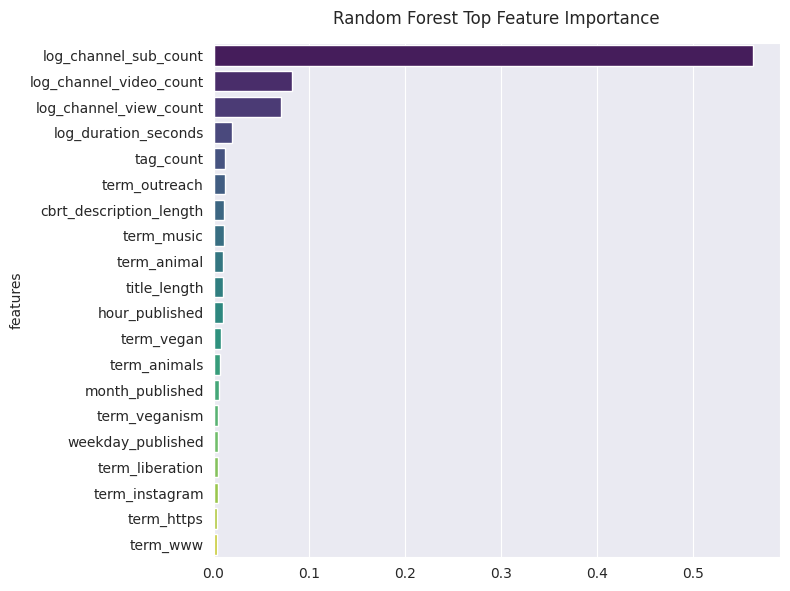

In [37]:
# visualize top 10 important features
sns.set_style("darkgrid")
plt.subplots(figsize=(8, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue=top_features.index, palette="viridis", legend=False, orient="h")
plt.title("Random Forest Top Feature Importance", y=1.02)
plt.ylabel("features")
plt.tight_layout()

# save png
plt.savefig("images/rf_top_feature_importance.png", dpi=300)

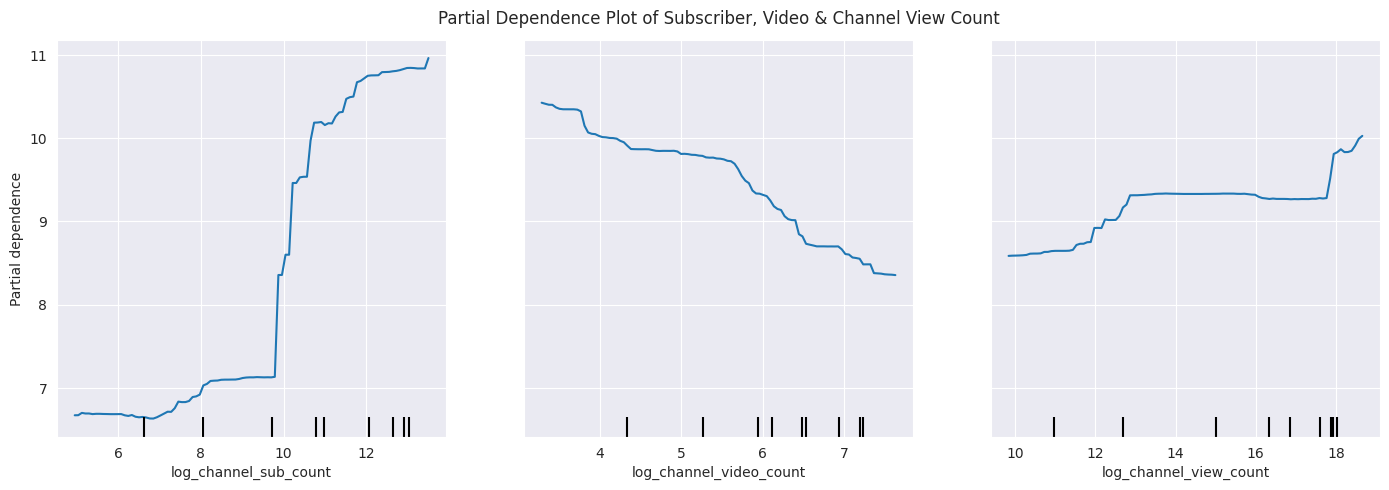

In [13]:
# visualize partial dependence for subscribers, video count & channel view count
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=pipeline, X=X_train, features=["log_channel_sub_count", "log_channel_video_count", "log_channel_view_count"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Subscriber, Video & Channel View Count", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/pdp_sub_video_channel_view_count.png", dpi=300)

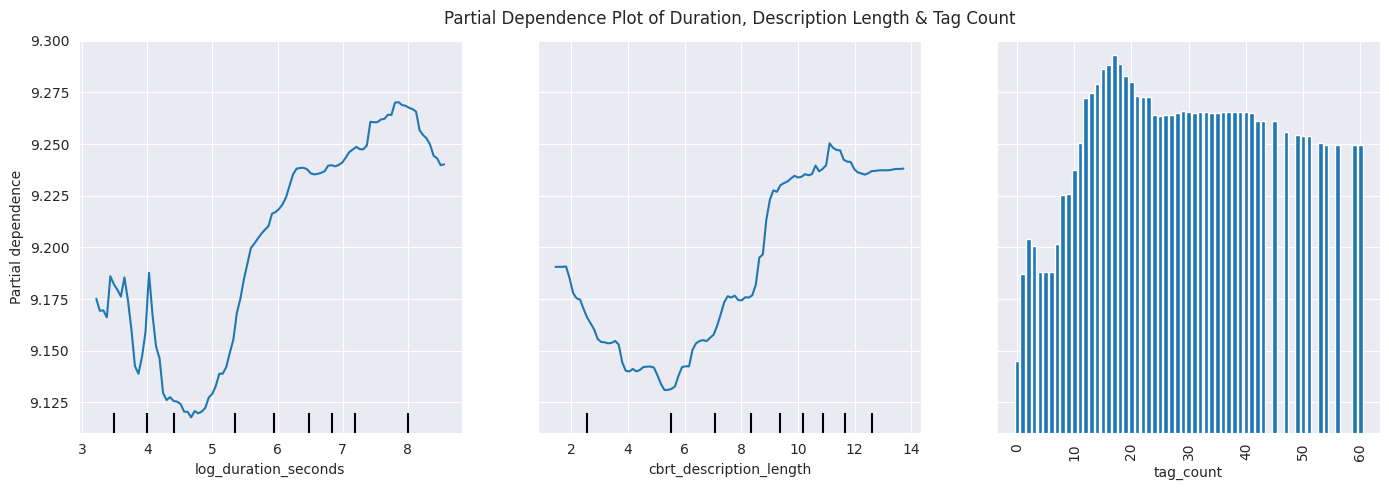

In [14]:
# visualize partial dependence for duration, description length & tag count
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=pipeline, X=X_train, features=["log_duration_seconds", "cbrt_description_length", "tag_count"], categorical_features=["tag_count"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Duration, Description Length & Tag Count", y=1.02)
plt.tight_layout()

# save fig
plt.savefig("images/pdp_duration_desc_length_tag_count.png", dpi=300)

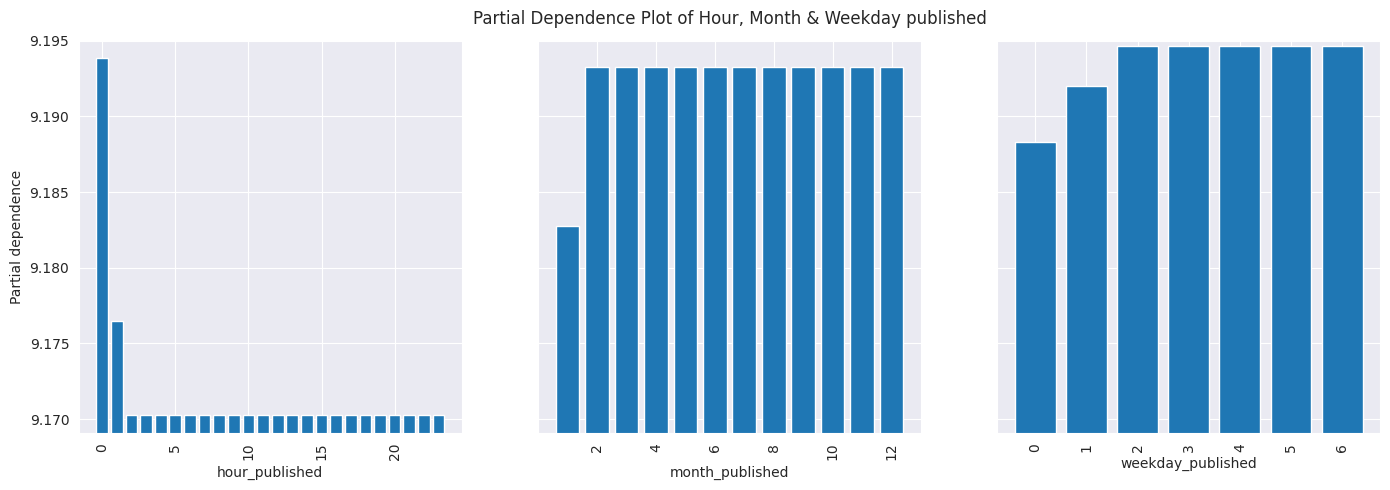

In [15]:
# visualize partial dependence for hour, month & weekday published
fig, ax = plt.subplots(figsize=(14, 5))
PartialDependenceDisplay.from_estimator(estimator=rf, X=X_train, features=["hour_published", "month_published", "weekday_published"], categorical_features=["hour_published", "month_published", "weekday_published"], ax=ax, grid_resolution=100)
ax.set_title("Partial Dependence Plot of Hour, Month & Weekday published", y=1.02)
plt.tight_layout()

# save png
plt.savefig("images/pdp_hour_month_weekday_pub.png", dpi=300)

In [39]:
# get the shap values of each feature
scaler = pipeline.named_steps["standardscaler"]
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
explainer = shap.TreeExplainer(rf)
shap_values = pd.DataFrame(explainer.shap_values(X_train_scaled), columns=X_train.columns)
shap_values.head()


,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_www,term_year,term_years,term_youtu,term_youtube,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
0,-0.003459,0.008930,0.006416,-0.001203,-0.000478,-0.000016,0.007708,-0.000862,0.000002,0.0,...,0.018132,0.001265,0.000428,0.006153,0.011694,-0.111639,1.686814,-0.345918,0.093542,0.058442
1,-0.003833,0.016531,-0.000673,-0.021358,-0.021421,-0.000004,-0.005588,0.001474,0.000019,0.0,...,-0.008632,0.001205,0.000116,-0.002689,-0.004553,-0.609604,-3.167853,0.326661,0.027683,-0.012880
2,-0.002810,0.012040,0.017020,0.011655,0.000501,-0.000008,-0.001091,0.002300,0.000037,0.0,...,-0.005145,0.002206,0.003493,-0.004822,0.003791,0.109669,0.716323,1.191791,0.189167,0.017857
3,-0.004029,0.009630,-0.007306,-0.005922,-0.000330,-0.000047,0.000749,0.000075,0.000005,0.0,...,0.009335,0.001204,0.000439,-0.005361,0.008711,-0.116640,1.700385,-0.425093,0.050898,-0.049874
4,-0.006211,-0.001095,-0.001896,0.018776,-0.000804,-0.000018,-0.000192,-0.000403,0.000002,0.0,...,0.003371,0.000642,0.000333,-0.004830,0.005141,0.372710,1.684388,-0.510210,0.098631,0.061468


In [40]:
# list the top term features
terms = []
for col in feature_importances.index:
    if col.startswith("term_"):
        terms.append(col)
top_terms = terms[:20]
top_terms

['term_outreach',
 'term_music',
 'term_animal',
 'term_vegan',
 'term_animals',
 'term_veganism',
 'term_liberation',
 'term_instagram',
 'term_https',
 'term_www',
 'term_com',
 'term_facebook',
 'term_video',
 'term_products',
 'term_support',
 'term_gains',
 'term_wayne',
 'term_youtube',
 'term_http',
 'term_join']

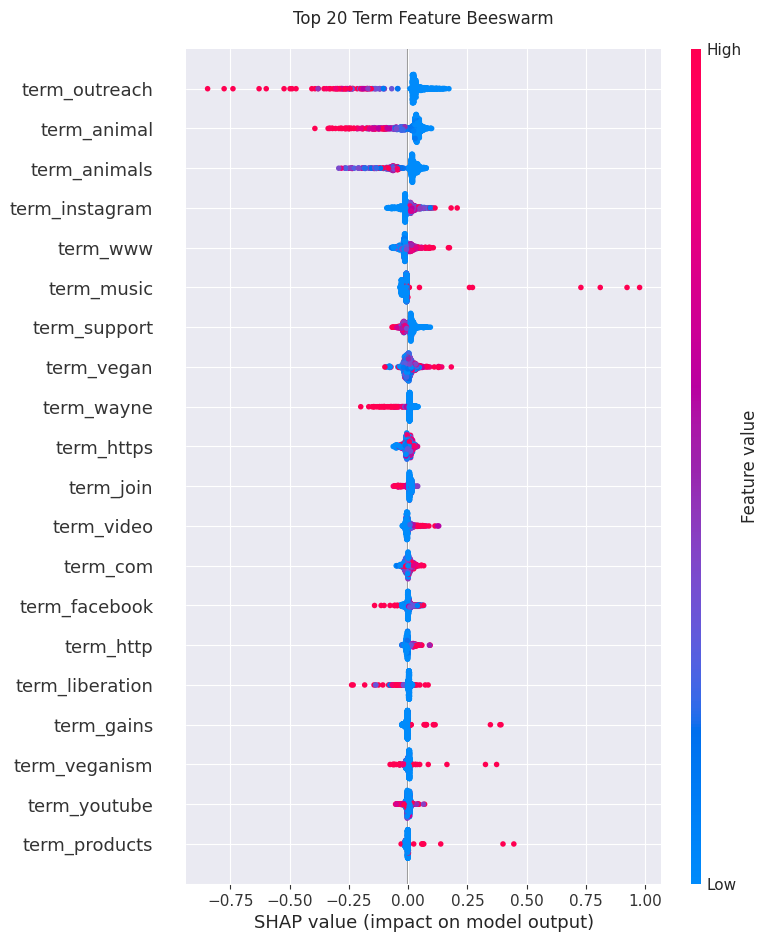

<Figure size 640x480 with 0 Axes>

In [45]:
# visualize beeswarm of top 20 term features
plt.title("Top 20 Term Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[top_terms].values, X_train_scaled[top_terms], plot_type="dot")
plt.tight_layout()

# save png
plt.savefig("images/term_beeswarm.png", dpi=300)

In [43]:
# list the category features
categories = []
for col in feature_importances.index:
    if col.startswith("cat_"):
        categories.append(col)
categories

['cat_Science & Technology',
 'cat_Music',
 'cat_People & Blogs',
 'cat_Education',
 'cat_Nonprofits & Activism',
 'cat_Pets & Animals',
 'cat_Howto & Style',
 'cat_Entertainment',
 'cat_News & Politics',
 'cat_Comedy',
 'cat_Film & Animation',
 'cat_Travel & Events',
 'cat_Gaming',
 'cat_Sports']

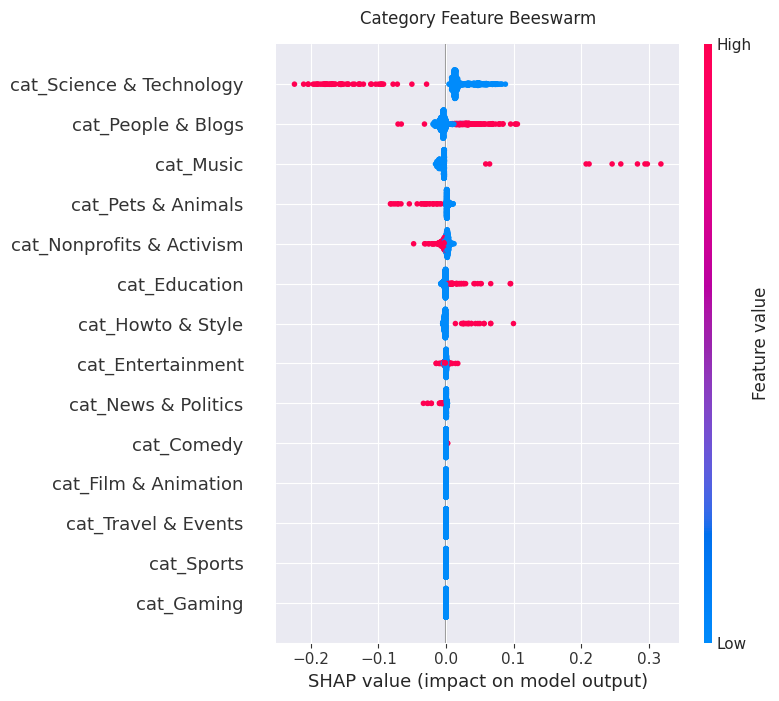

<Figure size 640x480 with 0 Axes>

In [46]:
# visualize beeswarm of category features
plt.title("Category Feature Beeswarm", y=1.02)
shap.summary_plot(shap_values[categories].values, X_train_scaled[categories], plot_type="dot")
plt.tight_layout()

# save png
plt.savefig("images/category_beeswarm.png", dpi=300)

In [ ]:
# convert log residuals to actual in video views and label with video and chanel title
labels = pd.read_csv("data/videos_prepared.csv", usecols=[0, 1, 2, 335])
labled_residuals = pd.merge(labels, residuals, left_index=True, right_index=True).rename(columns={"log_view_count_x": "log_view_count", "log_view_count_y": "log_residual"})
labled_residuals["log_predicted"] = labled_residuals["log_view_count"] - labled_residuals["log_residual"]
labled_residuals["act_view_count"] = np.expm1(labled_residuals["log_view_count"])
labled_residuals["act_predicted"] = np.expm1(labled_residuals["log_predicted"]).round(2)
labled_residuals["act_residual"] = labled_residuals["act_view_count"] - labled_residuals["act_predicted"]
labled_residuals = labled_residuals.iloc[:, [0,1,2,3,5,4,6,7,8]].sort_values("act_residual", key=abs, ascending=False)
labled_residuals.head(10)

,video_id,title,channel_title,log_view_count,log_predicted,log_residual,act_view_count,act_predicted,act_residual
756,Z3u7hXpOm58,You Will Never Look at Your Life in the Same W...,Earthling Ed,15.536755,12.091859,3.444896,5591482.0,178412.53,5413069.47
792,dmq6ai-4o8Y,why I went plant-based,Tiff Loves Tofu,14.710419,12.004314,2.706105,2447111.0,163457.42,2283653.58
119,3g-KqNqFA9Y,"Forget hummus, make this instead",Rainbow Plant Life,14.807298,13.961484,0.845813,2696047.0,1157164.92,1538882.08
636,0VHK8wpFci4,The breakfast that helped me lose 40lbs as a v...,Chelsea Mae,14.132579,11.834610,2.297970,1373096.0,137943.92,1235152.08
17,G5o4ym5in_w,A Masterclass On Plant-Based Nutrition | Rich ...,Rich Roll,13.884312,11.933443,1.950869,1071222.0,152273.90,918948.10
555,uQCe4qEexjc,Philip Wollen : Animals Should Be Off The Menu...,Kindness Trust,13.742726,9.373488,4.369238,929800.0,11771.10,918028.90
72,wCyQFdIu1Bg,Joaquin Phoenix On Why He's Vegan,Brut India,13.765239,12.151785,1.613454,950970.0,189430.96,761539.04
199,TVb0wsUnSM8,Vegan Food: What Do You ACTUALLY Eat?,Gabrielle Reyes,13.531658,10.344789,3.186869,752877.0,31093.59,721783.41
826,WIkC4OJEx3c,Gary Yourofsky's Speech: Q&A Session,TheAnimalHolocaust,13.404263,11.034530,2.369733,662822.0,61976.70,600845.30
472,bi1cfkksehM,Think From The Victim's Perspective #vegan #an...,Arvind Animal Activist,13.733994,12.720477,1.013516,921716.0,334527.52,587188.48


In [ ]:
# scale test features and get shap values
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
shap_values = pd.DataFrame(explainer.shap_values(X_test_scaled), columns=X_test.columns, index=X_test.index)
shap_values.head()

,caption,hour_published,weekday_published,month_published,hd,cat_Comedy,cat_Education,cat_Entertainment,cat_Film & Animation,cat_Gaming,...,term_www,term_year,term_years,term_youtu,term_youtube,log_channel_view_count,log_channel_sub_count,log_channel_video_count,log_duration_seconds,cbrt_description_length
757,-0.005726,0.000444,-0.012407,0.008071,-0.000114,-0.000006,-0.000938,0.000290,0.000019,0.0,...,0.002714,0.001943,0.002864,-0.004402,0.003740,-0.171974,1.565924,0.806621,0.011269,0.001210
607,-0.009520,0.035944,0.005345,-0.002329,0.001654,-0.000004,-0.001991,0.000465,0.000026,0.0,...,-0.009736,0.000705,0.000347,-0.003234,-0.005367,0.163843,-2.118739,0.272951,0.062465,0.017637
362,-0.013521,0.084360,0.007530,-0.007689,0.006428,-0.000006,-0.002069,0.000302,0.000003,0.0,...,0.001234,0.000712,-0.001185,-0.004974,-0.005680,0.430764,-1.620794,-0.310790,0.028828,0.012421
629,-0.004641,0.081897,-0.000210,0.002564,-0.002857,-0.000008,-0.003108,0.000323,0.000046,0.0,...,-0.014626,0.000845,0.001810,-0.002782,-0.001574,-0.114064,-2.529930,0.521230,0.004718,-0.040671
852,-0.004007,0.020776,0.002055,0.000675,-0.000102,-0.000006,-0.000576,-0.001112,-0.000135,0.0,...,-0.023333,0.001864,0.002219,-0.011373,0.005102,-0.154780,1.207740,0.145608,0.003760,0.007890


/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/shap/plots/_waterfall.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sval = values[order[i]]
/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/shap/plots/_waterfall.py:141: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.issubdtype(type(features[order[i]]), np.number):
/home/lance_lucifer/.pyenv/versions/3.12.3/lib/python3.12/site-packages/shap/plots/_waterfall.py:143: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

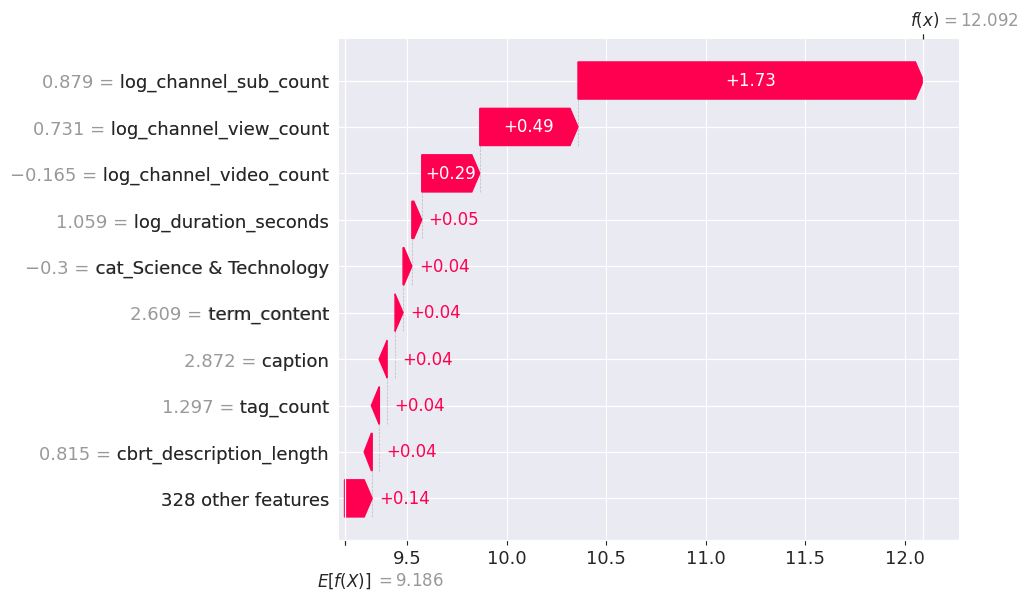

In [33]:
shap.waterfall_plot(shap.Explanation(values=shap_values.loc[756], base_values=explainer.expected_value, data=X_test_scaled.loc[756], feature_names=X_test_scaled.columns))

In [31]:
explainer.expected_value

array([9.18632431])